In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np


In [15]:
reader = open('barrier.log')
writer = open('barrier.csv', 'w')

for line in reader:
    result = re.search("\[(.*)\]\[(.*)\]", line)
    print(result.group(1), result.group(2), sep=',', file=writer)

In [16]:
df = pd.read_csv('barrier.csv', header=None)

# parse times from log file
# format 2023:281:11:30:50:9 to seconds since epoch

# convert to datetime

df[0] = pd.to_datetime(df[0], format='%Y:%j:%H:%M:%S:%f')

arrivals = df.where(df[1] == "_IN_").dropna()[0].reset_index()[0]
departures = df.where(df[1] == "_OUT").dropna()[0].reset_index()[0]

num_arrivals = len(arrivals)
num_departures = len(departures)

print("Number of arrivals: ", num_arrivals)
print("Number of departures: ", num_departures)

Number of arrivals:  1000
Number of departures:  1000


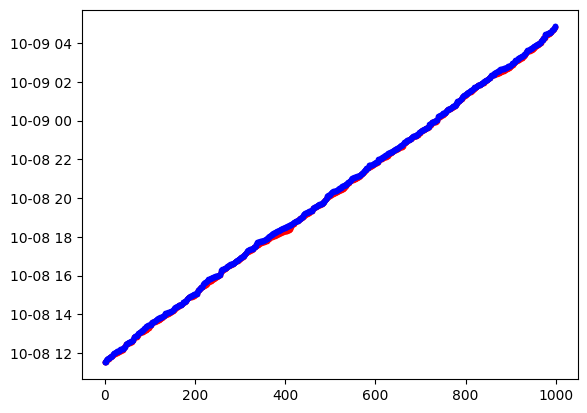

In [17]:
# plot arrivals and departures
arrivals.plot(style='r.')
departures.plot(style='b.')
plt.show()

# the system is stable and the last arrival corresponds to the last departure
# we can proceed with the normal analysis

In [18]:

T = (departures.values[-1] - arrivals[0])
print("Total time: ", T)

inter_arrival_times = arrivals.diff().dropna() # arrivals[1:] - arrivals[:-1]
average_inter_arrival_time = inter_arrival_times.mean().total_seconds()

arrival_rate = 1 / average_inter_arrival_time
throughput = arrival_rate

service_times = []
# compute completion times
for idx, value in enumerate(departures):
    target = arrivals[idx] if idx == 0 else max(arrivals[idx], departures[idx-1])
    service_times.append(value - target)

service_times = pd.Series(service_times)

average_service_time = service_times.mean().total_seconds()

utilization = service_times.sum() / T

response_times = departures - arrivals
average_response_time = response_times.mean().total_seconds()
W = response_times.sum()
average_number_jobs = W / T


Total time:  0 days 17:20:41.600000


In [19]:
# ma is arrivals array and value 1

MA = pd.DataFrame({'time': arrivals.values, 'value': 1})
MA.head()

MD = pd.DataFrame({'time': departures.values, 'value': -1})
MD.head()

M = pd.concat([MA, MD]).sort_values(by='time')
M

M["sum"] = M["value"].cumsum()

M

,time,value,sum
0,2023-10-08 11:30:50.900,1,1
0,2023-10-08 11:31:15.800,-1,0
1,2023-10-08 11:31:25.700,1,1
2,2023-10-08 11:31:31.500,1,2
3,2023-10-08 11:31:31.600,1,3
...,...,...,...
997,2023-10-09 04:50:34.300,-1,0
998,2023-10-09 04:50:41.400,1,1
999,2023-10-09 04:51:04.700,1,2
998,2023-10-09 04:51:29.500,-1,1


Probability of 0 jobs in the system:  0.131
Probability of 1 jobs in the system:  0.224
Probability of 2 jobs in the system:  0.159
Probability of 3 jobs in the system:  0.118
Probability of 4 jobs in the system:  0.0865


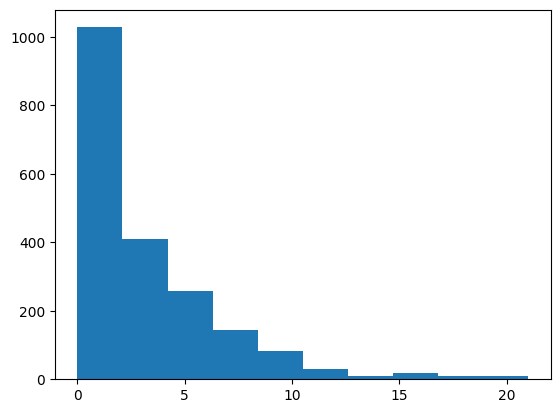

In [28]:
PM_0 = M["sum"].where(lambda x: x == 0).dropna().count() / len(M)
PM_1 = M["sum"].where(lambda x: x == 1).dropna().count() / len(M)
PM_2 = M["sum"].where(lambda x: x == 2).dropna().count() / len(M)
PM_3 = M["sum"].where(lambda x: x == 3).dropna().count() / len(M)
PM_4 = M["sum"].where(lambda x: x == 4).dropna().count() / len(M)

print("Probability of 0 jobs in the system: ", PM_0)
print("Probability of 1 jobs in the system: ", PM_1)
print("Probability of 2 jobs in the system: ", PM_2)
print("Probability of 3 jobs in the system: ", PM_3)
print("Probability of 4 jobs in the system: ", PM_4)



In [21]:
PRI_30 = response_times.where(lambda x: x < pd.Timedelta(seconds=30)).dropna().count() / len(response_times)
PRI_3_MIN = response_times.where(lambda x: x < pd.Timedelta(minutes=3)).dropna().count() / len(response_times)

print("Probability of response time less than 30 seconds: ", PRI_30)
print("Probability of response time less than 3 minutes: ", PRI_3_MIN)

Probability of response time less than 30 seconds:  0.162
Probability of response time less than 3 minutes:  0.624


In [22]:
PIRT = inter_arrival_times.where(lambda x: x < pd.Timedelta(seconds=60)).dropna().count() / len(inter_arrival_times)
print("Probability of inter-arrival time less than 60 seconds: ", PIRT)

Probability of inter-arrival time less than 60 seconds:  0.6266266266266266


In [29]:
PST = service_times.where(lambda x: x > pd.Timedelta(seconds=60)).dropna().count() / len(service_times)
print("Probability of service time greater than 60 seconds: ", PST)

Probability of service time greater than 60 seconds:  0.268


In [24]:

print("Average inter-arrival time: ", average_inter_arrival_time)
print("Arrival rate: ", arrival_rate)
print("Througput rate: ", throughput)
print("Average service time: ", average_service_time)
print("Utilization: ", utilization)
print("Average number of jobs: ", average_number_jobs)
print("Average response time: ", average_response_time)


# print(arrivals)
# print(departures)

Average inter-arrival time:  62.476276
Arrival rate:  0.016006075650219612
Througput rate:  0.016006075650219612
Average service time:  45.3463
Utilization:  0.7262193793881002
Average number of jobs:  2.791257751242761
Average response time:  174.2906
